Logistic Regression - MAP, Laplace and MH
----

In [1]:
import numpy as np
import pylab as plt
%matplotlib inline

In [2]:
trainx = np.loadtxt('trainx.csv',delimiter=',')
N = len(trainx)
traint = np.hstack((np.zeros(50),np.ones(50)))[:,None]

# Add a column of 1s, for a bias term
trainx = np.hstack((trainx,np.ones_like(traint)))

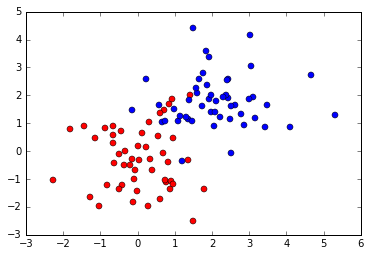

In [3]:
plt.figure()
pos0 = np.where(traint==0)[0]
pos1 = np.where(traint==1)[0]
plt.plot(trainx[pos0,0],trainx[pos0,1],'ro')
plt.plot(trainx[pos1,0],trainx[pos1,1],'bo')

Define the prior mean and covariance for $\mathbf{w}$

In [4]:
mu0 = np.zeros((3,1))
cov0 = np.eye(3)

Use the Newton-Raphson procedure to find the MAP estimate for $\mathbf{w}$

In [5]:
w = np.zeros((3,1))
dx = np.diag(np.dot(trainx,trainx.T))[:,None]
n_its = 20
allw = np.zeros((3,20))
for i in range(20):
    allw[:,i] = w.flatten()
    P = 1.0/(1.0 + np.exp(-np.dot(trainx,w)))
    gw = -w + np.sum(trainx*np.tile(traint-P,(1,3)),axis=0)[:,None]
    temp = trainx*np.tile(P*(1-P),(1,3))
    hw = -np.eye(3) - np.dot(temp.T,trainx)
    w = w - np.dot(np.linalg.inv(hw),gw)
    


Plot the evolution of the parameters to see that they converge

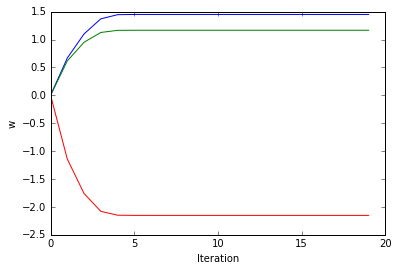

In [6]:
plt.plot(allw[0,:])
plt.plot(allw[1,:])
plt.plot(allw[2,:])
plt.xlabel('Iteration')
plt.ylabel('w')

In [7]:
xvals = np.arange(-3,6,0.1)
Ngrid = len(xvals)
gridpred = np.zeros((Ngrid,Ngrid))
for i in range(len(xvals)):
    for j in range(len(xvals)):
        pp = np.hstack((xvals[i],xvals[j],1))[:,None]
        gridpred[i][j] = 1/(1+np.exp(-np.dot(w.T,pp)))

<a list of 6 text.Text objects>

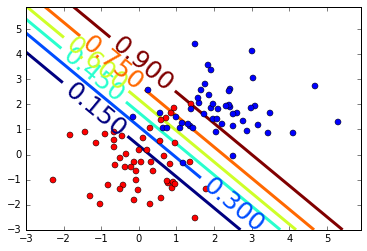

In [8]:
plt.figure()
pos0 = np.where(traint==0)[0]
pos1 = np.where(traint==1)[0]
plt.plot(trainx[pos0,0],trainx[pos0,1],'ro')
plt.plot(trainx[pos1,0],trainx[pos1,1],'bo')
A = plt.contour(xvals,xvals,gridpred.T,linewidths=3)
plt.clabel(A, inline=1, fontsize=25)

Laplace approximation
-----

In [9]:
lap_mean = w
lap_cov = -np.linalg.inv(hw)

Generate lots of samples

In [10]:
n_samps = 1000
w_samps = np.random.multivariate_normal(lap_mean.flatten(),lap_cov,n_samps)

Plot some of the sampled decision boundaries

(-3, 6)

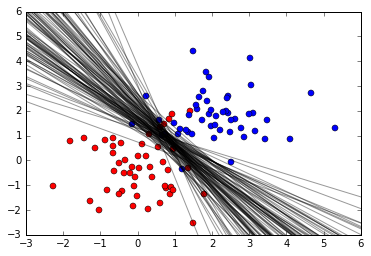

In [11]:
plt.figure()
pos0 = np.where(traint==0)[0]
pos1 = np.where(traint==1)[0]
plt.plot(trainx[pos0,0],trainx[pos0,1],'ro')
plt.plot(trainx[pos1,0],trainx[pos1,1],'bo')
xlims = np.array([-3,6])
for i in range(100):
    this_w = w_samps[i,:]
    ylims = (-this_w[2] - this_w[0]*xlims)/this_w[1]
    plt.plot(xlims,ylims,'k',alpha=0.4)
    
plt.ylim((-3,6))
    
    

Average over them to create the contours

In [12]:
gridpred = np.zeros((Ngrid,Ngrid))
for i in range(len(xvals)):
    for j in range(len(xvals)):
        pp = np.hstack((xvals[i],xvals[j],1))[:,None]
        gridpred[i][j] = (1/(1+np.exp(-np.dot(w_samps,pp)))).mean()

<a list of 6 text.Text objects>

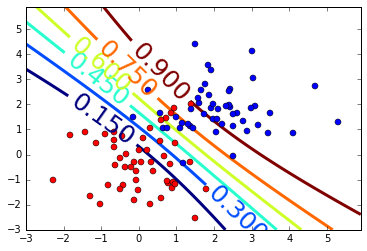

In [13]:
plt.figure()
pos0 = np.where(traint==0)[0]
pos1 = np.where(traint==1)[0]
plt.plot(trainx[pos0,0],trainx[pos0,1],'ro')
plt.plot(trainx[pos1,0],trainx[pos1,1],'bo')
A = plt.contour(xvals,xvals,gridpred.T,linewidths=3)
plt.clabel(A, inline=1, fontsize=25)

Metropolis-Hastings sampling

In [15]:
w = np.zeros_like(w)
n_samps = 10000
w_samps = np.zeros((n_samps,3))
old_like = -0.5*np.dot(np.dot(w.T,np.eye(3)),w)
old_like += (traint*np.log(1.0/(1+np.exp(np.dot(-trainx,w))))).sum()
old_like += ((1-traint)*np.log(1 - 1.0/(1+np.exp(np.dot(-trainx,w))))).sum()
for s in range(n_samps):
    # Propose a value
    w_new = w + np.random.normal(0,1,(3,1))
    new_like = -0.5*np.dot(np.dot(w_new.T,np.eye(3)),w_new)
    new_like += (traint*np.log(1.0/(1+np.exp(np.dot(-trainx,w_new))))).sum()
    new_like += ((1-traint)*np.log(1 - 1.0/(1+np.exp(np.dot(-trainx,w_new))))).sum()
    if np.random.rand() <= np.exp(new_like - old_like):
        w = w_new
        old_like = new_like
    w_samps[s,:] = w.T


Plot some of the sampled decision boundaries

(-3, 6)

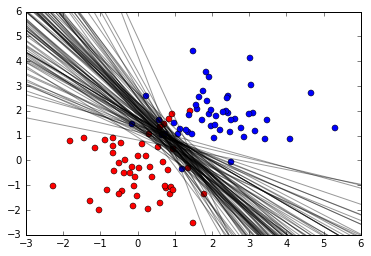

In [16]:
plt.figure()
pos0 = np.where(traint==0)[0]
pos1 = np.where(traint==1)[0]
plt.plot(trainx[pos0,0],trainx[pos0,1],'ro')
plt.plot(trainx[pos1,0],trainx[pos1,1],'bo')
xlims = np.array([-3,6])
for i in range(100):
    this_w = w_samps[np.random.randint(n_samps),:]
    ylims = (-this_w[2] - this_w[0]*xlims)/this_w[1]
    plt.plot(xlims,ylims,'k',alpha=0.4)
    
plt.ylim((-3,6))
    

Average the predictions over the grid

In [17]:
gridpred = np.zeros((Ngrid,Ngrid))
for i in range(len(xvals)):
    for j in range(len(xvals)):
        pp = np.hstack((xvals[i],xvals[j],1))[:,None]
        gridpred[i][j] = (1/(1+np.exp(-np.dot(w_samps,pp)))).mean()

<a list of 6 text.Text objects>

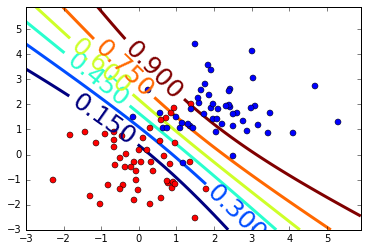

In [18]:
plt.figure()
pos0 = np.where(traint==0)[0]
pos1 = np.where(traint==1)[0]
plt.plot(trainx[pos0,0],trainx[pos0,1],'ro')
plt.plot(trainx[pos1,0],trainx[pos1,1],'bo')
A = plt.contour(xvals,xvals,gridpred.T,linewidths=3)
plt.clabel(A, inline=1, fontsize=25)